# Music Generation

In [this project](https://github.com/RasmusML/musicHMM), we will generate music notes using hidden markov models. The models are trained on Bach pieces.

We will explore X models. The first model is a standard HMM-1 and implemented from scratch. The remaning X models are implemented in the probablistic framework Pyro, which simplifies implementing the model - as the procedure (a modified Baum welch implementation) used to optimize the models weights does not need to be implemented as well.
Instead of using Pyro, we could had implemented the models in pyTorch, since the backpropogation algorithm can be used to optimize the weights - but I opted for Pyro.

Overview of the models:
- HMM-0: single-note, fixed-length
- HMM-1: multiple notes, fixed-length

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.infer import SVI, TraceEnum_ELBO
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam, ClippedAdam

from utils import *
from hmm import HMM

np.random.seed(0)

## Data exploration

The JSB chorales are a set of short, four-voice pieces of music well-noted for their stylistic homogeneity. The chorales were originally composed by Johann Sebastian Bach in the 18th century. He wrote them by first taking pre-existing melodies from contemporary Lutheran hymns and then harmonising them to create the parts for the remaining three voices. The version of the dataset used canonically in representation learning contexts consists of 382 such chorales. These pieces are stored in MIDI format.

Let"s load the data.

In [3]:
data = load_jsb_chorales()

In [4]:
notes = [note for chorale in data for t_note in chorale for note in t_note]
lowest_note = np.min(notes)
highest_note = np.max(notes)

print(f"Lowest note: {lowest_note}")
print(f"Highest note: {highest_note}")

Lowest note: 23
Highest note: 76


The notes are indexed from 1 to 88, where 1 is the lowest note on the piano and 88 is the highest note. The note 0 is interpreted as no note being played. 

Let's look at the distributions.

Text(0.5, 1.0, 'Histogram of notes')

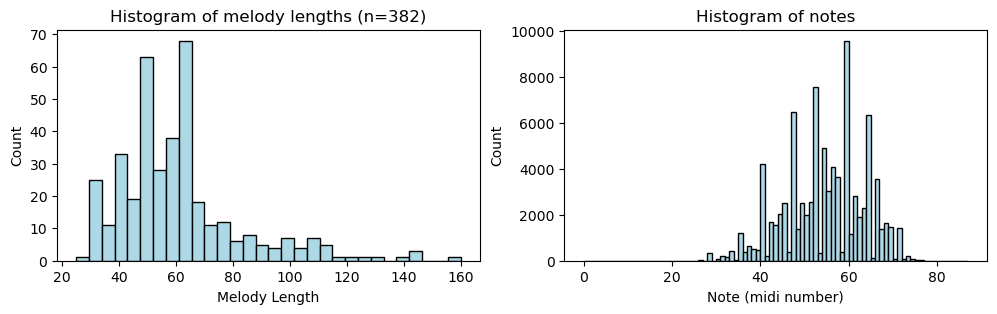

In [5]:
lengths = [len(song) for song in data]

fig, axes = plt.subplots(figsize=(12,3), ncols=2)
ax = axes[0]
ax.hist(lengths, bins=30, color="lightblue", edgecolor="black")
ax.set_xlabel("Melody Length")
ax.set_ylabel("Count")
ax.set_title(f"Histogram of melody lengths (n={len(data)})") 

ax = axes[1]
notes = [note for chorale in data for t_note in chorale for note in t_note]
ax.hist(notes, bins=range(0, 88), color="lightblue", edgecolor="black")
ax.set_xlabel("Note (midi number)")
ax.set_ylabel("Count")
ax.set_title("Histogram of notes")

In [6]:
# @TODO: histogram of intervals (difference between consecutive notes)
# @TODO: 2d heatmap of absolute jumps between notes?

Let's listen to an example melody.

In [7]:
x_example = data[0]
write_mp3(x_example, "out/example_all.mp3")

In [8]:
audio_widget("out/example_all.mp3")

# Single note

### Data Preprocessing

Let's only look at the top voice for now.

In [9]:
single_data = []

for sequence in data:
    notes = [[chords[0]] if len(chords) > 0 else [0] for chords in sequence]
    single_data.append(notes)

Let's split the data into sets.

In [10]:
seqs_train = single_data[:290]
seqs_val   = single_data[290:330]
seqs_test  = single_data[330:]

print(f"Number of sequences in train: {len(seqs_train)} ({len(seqs_train)/len(single_data)*100:.2f}%)")
print(f"Number of sequences in val: {len(seqs_val)} ({len(seqs_val)/len(single_data)*100:.2f}%)")
print(f"Number of sequences in test: {len(seqs_test)} ({len(seqs_test)/len(single_data)*100:.2f}%)")

Number of sequences in train: 290 (75.92%)
Number of sequences in val: 40 (10.47%)
Number of sequences in test: 52 (13.61%)


Let's listen to the sound now.

In [11]:
x_examples = seqs_train[0]

write_mp3(x_examples, "out/example_single.mp3")

audio_widget("out/example_single.mp3")

### HMM-0

A simple HMM model has already been implemented many times in the past. Nevertheless, we will implement it from scratch again. The implementation uses log probabilities to avoid numerical underflow. The model is trained using the Baum-Welch algorithm, and tests have been created to verify the correctness of the implementation. The viterbi algorithm for predicing the most plausible hidden sequence has also been implemented and tested.

In [12]:
x_train = np.array([note[0] for song in seqs_train for note in song])
lengths = np.array([len(song) for song in seqs_train])

In [13]:
n_iter = 40

model = HMM(n_hidden=4, n_obs=highest_note+1)
model.fit(x_train, lengths, n_iter=n_iter)

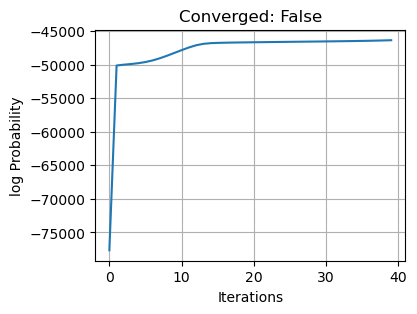

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(model._history)
ax.set_title(f"Converged: {len(model._history) < n_iter}")
ax.set_xlabel("Iterations")
ax.set_ylabel("log Probability")
ax.grid()

In [15]:
x_sample, state_sequence = model.sample(50)

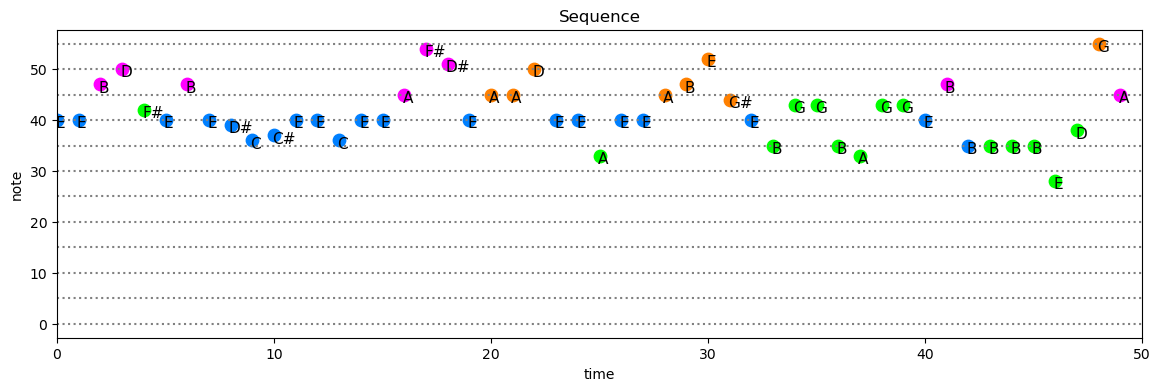

In [16]:
plot_sequence(idx_to_onehot(x_sample), state_sequence)

In [17]:
write_mp3([[note] for note in x_sample], "out/hmm0_example.mp3")

audio_widget("out/hmm0_example.mp3")

## Multiple notes

### Data preprocessing

Let's now use up to 4 notes per time step.

In [18]:
seqs_train = data[:290]
seqs_val   = data[290:330]
seqs_test  = data[330:]

### HMM-1

Let's jump directly to pyro implementations and this time also evalulate the model on the validation set.

In [19]:
def model_1(sequences, lengths, data_dim, hidden_dim, batch_size=None, include_prior=False):
    if sequences is not None:
        num_sequences, max_length, _ = map(int, sequences.shape)
    else:
        # when sampling, sample a single sequence
        num_sequences = 1
        max_length = lengths.max()

    assert lengths.shape == (num_sequences,)
    assert lengths.max() <= max_length
    
    with poutine.mask(mask=include_prior):
        probs_x = pyro.sample(
            "probs_x",
            dist.Dirichlet(0.9 * torch.eye(hidden_dim) + 0.1).to_event(1),
        )
        probs_y = pyro.sample(
            "probs_y",
            dist.Beta(0.1, 0.9).expand([hidden_dim, data_dim]).to_event(2),
        )
    
    tones_plate = pyro.plate("tones", data_dim, dim=-1)
    
    x_seq = torch.zeros(max_length, dtype=torch.long)
    y_seq = torch.zeros(max_length, data_dim)

    with pyro.plate("sequences", num_sequences, batch_size, dim=-2) as batch:
        lens = lengths[batch]
        x = 0
        for t in pyro.markov(range(lens.max())):
            with poutine.mask(mask=(t < lens).unsqueeze(-1)):
                x = pyro.sample(
                    "x_{}".format(t),
                    dist.Categorical(probs_x[x]),
                    infer={"enumerate": "parallel"},
                )
                x_seq[t] = x[0]

                with tones_plate:
                    y_seq[t] = pyro.sample(
                        "y_{}".format(t),
                        dist.Bernoulli(probs_y[x.squeeze(-1)]),
                        obs=sequences[batch, t] if sequences is not None else None,
                    )[0]

    return y_seq, x_seq

In [20]:
lengths = torch.tensor([len(song) for song in seqs_train])
max_length = lengths.max()
n_sequences = len(seqs_train)

In [21]:
sequences = torch.from_numpy(idx_to_onehot_multi(seqs_train)).float()

In [22]:
hidden_dim = 6
num_steps = 200
batch_size = 12

In [23]:
pyro.set_rng_seed(42)
pyro.clear_param_store()

In [24]:
model = model_1

In [25]:
guide = AutoDelta(
    poutine.block(model, expose_fn=lambda msg: msg["name"].startswith("probs_"))
)

optim = ClippedAdam({"lr": 1e-1})

elbo = TraceEnum_ELBO(
    max_plate_nesting=2,
    strict_enumeration_warning=True,
)
svi = SVI(model, guide, optim, elbo)

In [26]:
data_dim = sequences.shape[-1]

In [27]:
losses = []

for step in range(num_steps):
    loss = svi.step(sequences, lengths, data_dim=data_dim, hidden_dim=hidden_dim, batch_size=batch_size)
    losses.append(loss)

    # @TODO: compute validation loss
    # https://forum.pyro.ai/t/how-to-get-validation-loss-in-svi/4037

    if step % 10 == 0:
        print(f"Step {step} loss = {loss:.4f}")


Step 0 loss = 433998.5938
Step 10 loss = 288602.8750
Step 20 loss = 273352.1250
Step 30 loss = 273924.0625
Step 40 loss = 185775.2969
Step 50 loss = 162804.3125
Step 60 loss = 212481.6094
Step 70 loss = 196132.0000
Step 80 loss = 186560.9531
Step 90 loss = 185110.8438
Step 100 loss = 163421.4062
Step 110 loss = 191300.6719
Step 120 loss = 205013.9531
Step 130 loss = 161421.2500
Step 140 loss = 153834.0938
Step 150 loss = 139572.7344
Step 160 loss = 163736.8438
Step 170 loss = 155104.4688
Step 180 loss = 159697.2188
Step 190 loss = 146066.5625


In [28]:
# @TODO: compute test loss

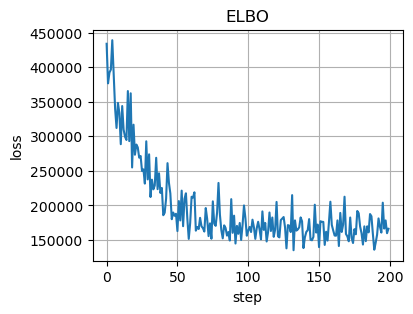

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(losses)
ax.set_title("ELBO")
ax.set_xlabel("step")
ax.set_ylabel("loss")
ax.grid()

In [40]:
"""
pyro.render_model(
    model,
    model_args=(sequences, lengths, data_dim, hidden_dim,),
    #render_distributions=True,
)
"""

'\npyro.render_model(\n    model,\n    model_args=(sequences, lengths, data_dim, hidden_dim,),\n    #render_distributions=True,\n)\n'

In [31]:
trained_model = poutine.condition(model, guide())

n_samples = 100
posterior_samples, posterior_hidden = trained_model(None, torch.tensor([n_samples]), data_dim, hidden_dim)

posterior_samples = posterior_samples.numpy()
posterior_hidden = posterior_hidden.numpy()

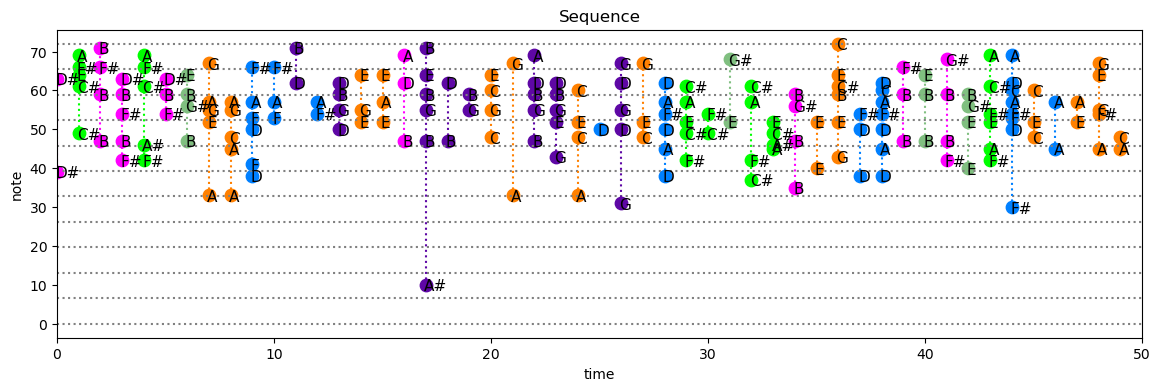

In [32]:
n = 50

plot_sequence(posterior_samples[:n], posterior_hidden[:n])

In [34]:
ps = posterior_samples > 0.5

np.sum(ps)

400

In [35]:
x_samples = posterior_samples.astype(int)
idx_sequence = [one_hot_to_idx(sequence) for sequence in x_samples]

In [36]:
x_example = idx_sequence

write_mp3(x_example, "out/hmm1_example.mp3")
audio_widget("out/hmm1_example.mp3")

### HMM-2